# CART (classification and regression tree)



In [1]:

import math
import random
random.seed(42)
import numpy as np
from queue import PriorityQueue
# graph library for the tree structure
import networkx as nx
# stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydot
from networkx.drawing.nx_pydot import graphviz_layout


#### Constants

In [2]:
# sample size 
n = 500
# dim x [0,10]
dim_x_min = 0
dim_x_max = 10
# dim y [0,4]
dim_y_min = 0
dim_y_max = 4

#### Model Parameter

In [3]:
# complexity_penalty_max
gamma = 0.6
maximum_deepth = 10
maximum_splits = 100

#### Target function

In [4]:
# Y = lambda x : 3 if x < 3 or x > 6 else 1 # math.sin(x) + 0.3*x
Y = lambda x : math.sin(x*1) + 0.3*x

#### Sample Data
generate n random point on the plane an give them label 
    
* $y_{x} \ge Y_{x} \Rightarrow blue$
* $y_{x} < Y_{x} \Rightarrow orange$

        blue == 0
        orange == 1

In [5]:
# list with tuple (x, y) and label ('b' or 'o')
Yi = np.empty((n,3))
for i in range(n):
    Yi[i,0] = dim_x_min + (random.random() * dim_x_max)
    Yi[i,1] = dim_y_min + (random.random() * dim_y_max)
    if Yi[i,1] >= Y(Yi[i,0]):
        Yi[i][2] = 0
    else:
        Yi[i][2] = 1

transfrom label to color for plotting

In [6]:
# transfrom label to color 
cols = []
for c in Yi[:,2]:
    if c == 0:
        cols.append('blue')
    else:
        cols.append('orange')

<function matplotlib.pyplot.show(close=None, block=None)>

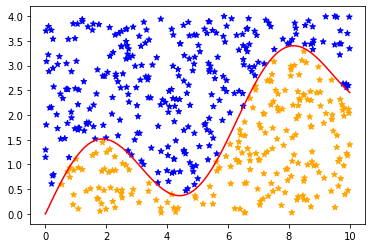

In [7]:
sc = plt.scatter(Yi[:,0], Yi[:,1], c=cols, alpha=1, marker='*')

plt.plot(np.linspace(0,10,100), [Y(x) for x in np.linspace(0,10,100)] , color='red')
#br = plt.plot(x,y, color='red')
plt.show

## CART Algorithm
+   Partition the Space of Possibility into $M$ Partitions $R_m$

+   for each Region a constant $c_m$ is defined which specifies the prediction for that region

+   in our case we have 2 dimensional input (here called $X_1$ and $X_2$)

+   $\hat f(X)=\underset{m=1}{\overset{M}\sum}{c_mI(x\in R_m)}$

    +   in regression mode: $\hat c_m=ave(y_i|x_i\in R_m)$
    *   in classification: $\hat c_m= \{k | \underset{k \in K}{\max}(N_{m,k})\}$\
        $k \in K$ are the possible Classes\
        $N_{mk}=\#\{x_i\in R_m  \land x_i\in k\}$ is the number of records of a class in a specific region

### Gini Index
*   the use of the  to quantify the "purity" or "heterogeneity"

*   $G(R)=\overset{K}{\underset{k=1}\sum}\hat p_{mk}(1-\hat p_{mk})$
    *   in our case of two categories this can be simplified to:\
        $G(R)=\hat p_{mk}(1-\hat p_{mk})$

### Complexity reduction
*   favor splits points that create even sized Regions

*   $C(s_{im})=|\frac{s_{im}-\min[R_{im}]}{\max[R_{im}]-\min[R_{im}]}-0.5|$

    *   $s_i$ the split point for variable $X_i$

    *   $\min[R_{im}]$ is the minimum variable possible in region $R_m$
    
    *   $\max[R_{im}]$ is the maximum variable possible in region $R_m$

### Greedy recursive split
1.  Select the least "pure" region $R_p$

2.  Split $R_p$ into to half-planes $R_1$ and $R_2$ in the splitting variable $j$ at point $s$\
    with $R_1(j,s)=\{X|X_j\leq s\}$ and $R_1(j,s)=\{X|X_j>s\}$

3.  generic opimizer for  $j$ and $s$:\
\
    $\underset{j,s}\min\big\lgroup\underset{c_1}\min\underset{x_i\in R_1(j,s)}\sum(y_i-c_1)^2+\underset{c_2}\min\underset{x_i\in R_2(j,s)}\sum(y_i-c_2)^2\big\rgroup$\
\
    problem specific optimizer:\
\
    $\underset{j,s}\min\big\lgroup\underset{v=1}{\overset{2}\sum}G(R_v)+\alpha C(s_{jv}) \big\rgroup$
    *   $\alpha$ defines the weighting bewteen "purity" and complexity (Model parameter)

3. Repeat until a stop criterion is meet
    *   maximum deepth reached

    *   maximum amount of splits reached
    
    *   the "purity" of all regions is under a specified threshold   

### Perimeter minimization (NOT IMPLEMENTED)
*   when gini + complexity are equal for both possible splits -> choose the one along the axis with the larger difference of max and min
    +   example score is equal and max/min for x and y is 10/5 and 3/1
    +   in this case split along x
+ this ensures a more square form for the resulting splits 
 


In [8]:
def calc_gini_idx(p1_label, p2_label):
    p1_sum = np.sum(p1_label)
    p2_sum = np.sum(p2_label)
    p1_proportion = p1_sum / len(p1_label)
    p2_proportion = p2_sum / len(p2_label)
    p1_gini_idx = p1_proportion * (1 - p1_proportion)
    p2_gini_idx = p2_proportion * (1 - p2_proportion)
    return p1_gini_idx + p2_gini_idx

def complexity_penalty(i, size, max_penalty):
    assert i<= size
    assert i >= 0
    assert size > 0
    return abs(i/size - 0.5) * 2 * max_penalty

def tree_split(Yi, complx_pen):
    # check for var x 
    # sort list by x (low to high)
    Yi_xs = Yi[Yi[:,0].argsort()]
    # iter over it, for each split deterining the purity of resulting partitions
    x_best_split_idx = 1
    x_best_split_gini_idx = 1 # one is max -> happens when both partition are max (0.5) hetrogen
    for i in range(1, len(Yi)):
        p1_sum = np.sum(Yi_xs[:i,2])
        p2_sum = np.sum(Yi_xs[i:,2])
        p1_proportion = p1_sum / i
        p2_proportion = p2_sum / (len(Yi) - i)
        p1_gini_idx = p1_proportion * (1 - p1_proportion)
        p2_gini_idx = p2_proportion * (1 - p2_proportion)
        p_gini_idx = calc_gini_idx(Yi_xs[:i,2], Yi_xs[i:,2]) + complexity_penalty(i, len(Yi), complx_pen)
        assert p_gini_idx == p1_gini_idx+p2_gini_idx  + complexity_penalty(i, len(Yi), complx_pen)
        
        if p_gini_idx < x_best_split_gini_idx:
            x_best_split_gini_idx = p_gini_idx
            x_best_split_idx = i
    # check best for var y
    Yi_ys = Yi[Yi[:,1].argsort()]
    # iter over it, for each split deterining the purity of resulting partitions
    y_best_split_idx = 1
    y_best_split_gini_idx = 1 # one is max -> happens when both partition are max (0.5) hetrogen
    for i in range(1, len(Yi)):
        p1_sum = np.sum(Yi_ys[:i,2])
        p2_sum = np.sum(Yi_ys[i:,2])
        p1_proportion = p1_sum / i
        p2_proportion = p2_sum / (len(Yi) - i)
        p1_gini_idx = p1_proportion * (1 - p1_proportion)
        p2_gini_idx = p2_proportion * (1 - p2_proportion)
        p_gini_idx = calc_gini_idx(Yi_ys[:i,2], Yi_ys[i:,2]) + complexity_penalty(i, len(Yi), complx_pen)
        assert p_gini_idx == p1_gini_idx+p2_gini_idx + complexity_penalty(i, len(Yi), complx_pen)
        if p_gini_idx < y_best_split_gini_idx:
            y_best_split_gini_idx = p_gini_idx
            y_best_split_idx = i
    # choose the one that brings more purity (lower gini_idx)
    if x_best_split_gini_idx <= y_best_split_gini_idx:
        return Yi_xs[:x_best_split_idx], Yi_xs[x_best_split_idx:], 'x' , (Yi_xs[x_best_split_idx - 1,0] + Yi_xs[x_best_split_idx,0]) / 2 
    else:
        return Yi_ys[:y_best_split_idx], Yi_ys[y_best_split_idx:], 'y' , (Yi_ys[y_best_split_idx - 1,1] + Yi_ys[y_best_split_idx,1]) / 2

def cart(Yi, max_deepth = 3, max_splits = 10, complx_pen = 0.5):
    split_count = 0
    node_name_counter = 0
    # store the partitions with negative purity so the most unpure are selected next
    DG = nx.DiGraph()
    DG.add_node("root")
    pq = PriorityQueue()
     # -purity, node_name, current_deepth, list
    pq.put((-(np.sum(Yi[:,2]) / len(Yi)) * (1 - (np.sum(Yi[:,2]) / len(Yi))), "root", 0, Yi))

    while not pq.empty():
        purity, node_name, current_deepth, list  = pq.get()
        if current_deepth >= max_deepth or split_count >= max_splits or purity == 0.0:
            # end it here
            DG.nodes[node_name]['end'] = round(np.sum(list[:,2]) / len(list))
        else:
            # split and add to queue
            (p1, p2, axis, cutpoint) = tree_split(list, complx_pen)
            split_count += 1
            # p1 <= cutpoint and p2 > cutpoint
            # add the variable to split between to the parent node
            DG.nodes[node_name]['split_axis']  = axis
            DG.nodes[node_name]['split_value'] = cutpoint
            # create two new nodes for each partition and connect them with edges to node_name (the parent)
            node_name_counter += 1
            lower_node_name =  f't{node_name_counter}'
            node_name_counter += 1
            higher_node_name = f't{node_name_counter}'
            DG.add_node(lower_node_name)
            DG.add_node(higher_node_name)   
            # connect the new nodes with edges to the parent node (add <= or > as identifier)
            DG.add_edge(node_name, lower_node_name, cutpoint_relation='lowerequal')                
            DG.add_edge(node_name, higher_node_name, cutpoint_relation='greater')
            # calc purity of the new nodes for prio in queue
            lower_node_purity = (np.sum(p1[:,2]) / len(p1)) * (1 - (np.sum(p1[:,2]) / len(p1)))
            higher_node_purity = (np.sum(p2[:,2]) / len(p2)) * (1 - (np.sum(p2[:,2]) / len(p2)))
            # push new partitions (nodes) to the queue for further spliting
            pq.put((-lower_node_purity, lower_node_name, current_deepth + 1, p1))
            pq.put((-higher_node_purity, higher_node_name, current_deepth + 1, p2))
    return DG

#### Create a decision tree

In [9]:
dg = cart(Yi, maximum_deepth, maximum_splits, gamma)

#### Plot the descision tree

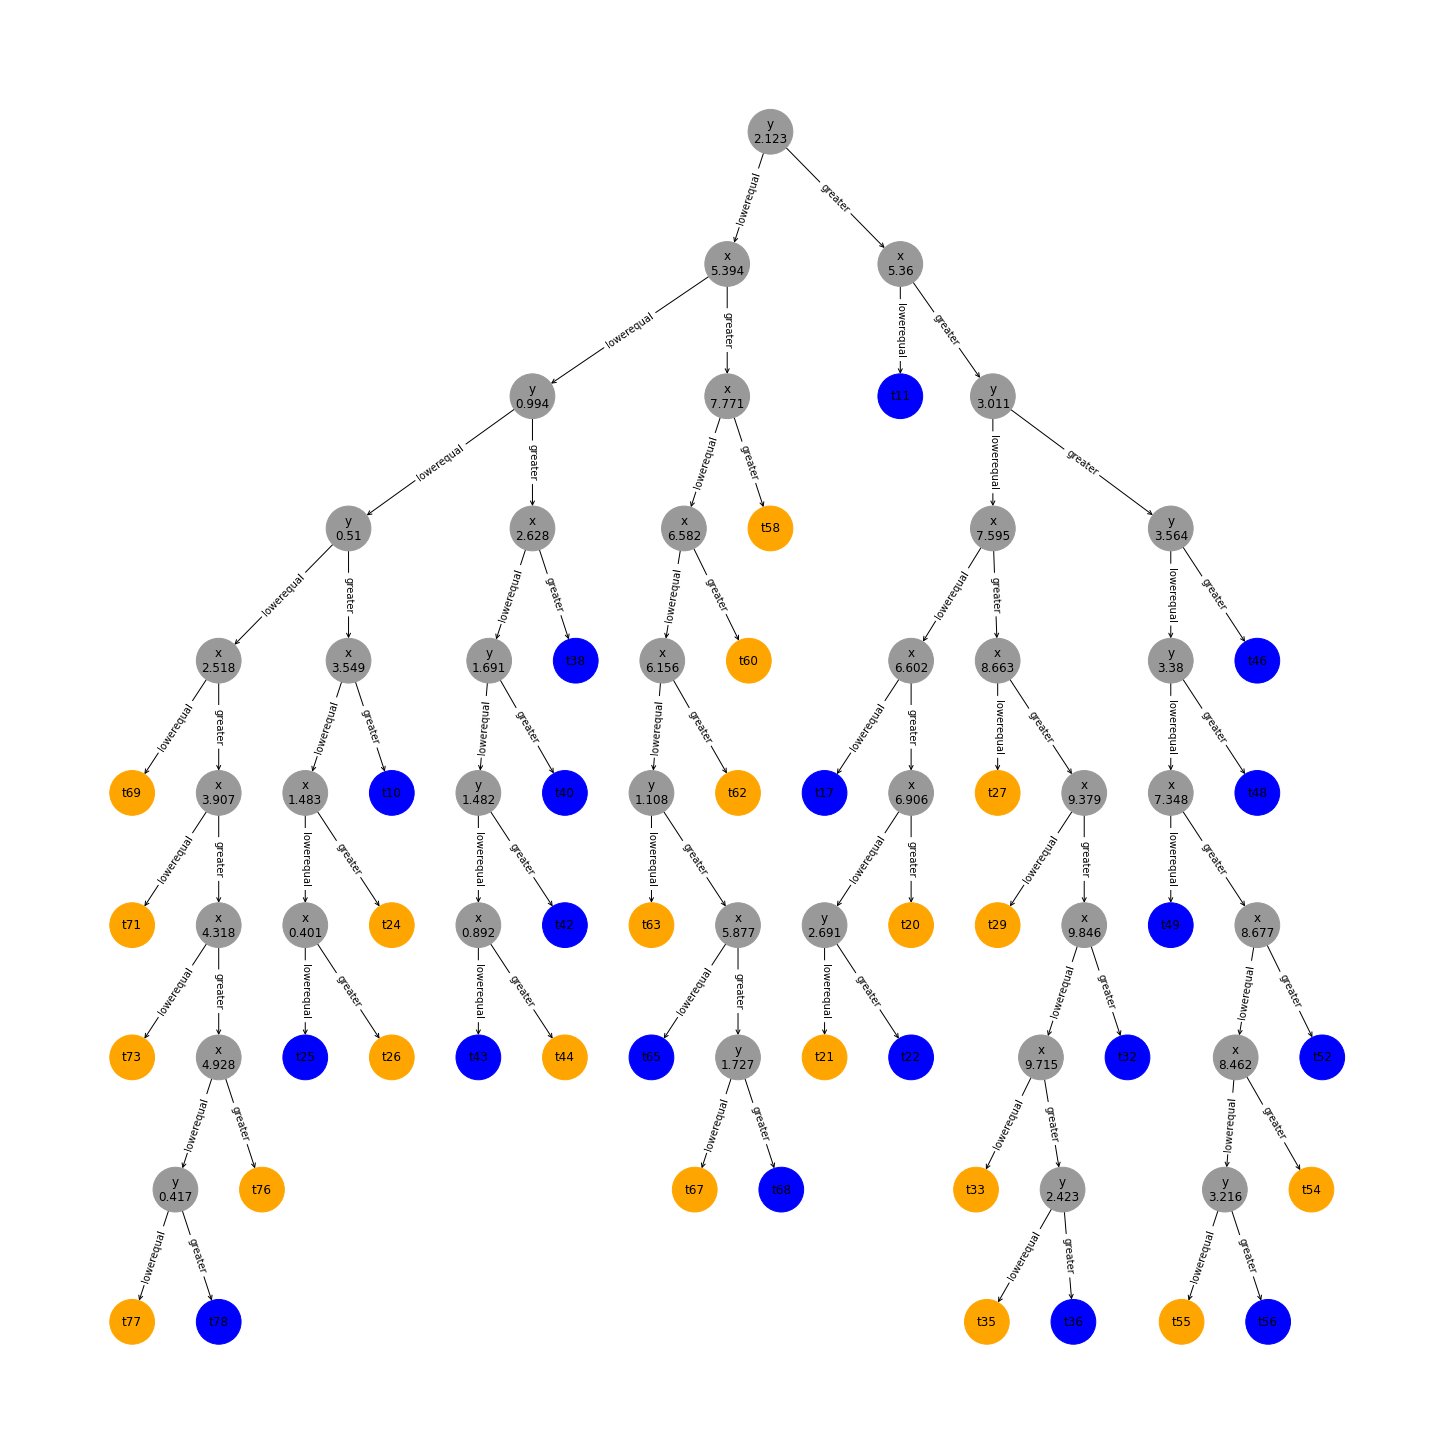

In [10]:
plt.figure(1,figsize=(20,20)) 
pos = graphviz_layout(dg, prog="dot", root='root')
# set color for nodes 
# end -> blue or orange; split ->gray
color_map_node = []
for node in dg:
    node_dict = dg.nodes[node]
    if node_dict.get('end') is None:
        color_map_node.append('0.6')
    elif node_dict.get('end') == 0:
        color_map_node.append('blue')
    else:
        color_map_node.append('orange')
# draw the graph with a hierarchical layout
nx.draw(dg, pos, with_labels=False, node_size=2000, node_color=color_map_node, arrowstyle='->')
# diplay the label on the edges
edge_labels = nx.get_edge_attributes(dg,'cutpoint_relation')
nx.draw_networkx_edge_labels(dg, pos, edge_labels = edge_labels)
# fill the nodes (not end point) with the split variable and value 
node_axis = nx.get_node_attributes(dg,'split_axis')
node_labels = nx.get_node_attributes(dg,'split_value')
for k, v in node_labels.items():
    node_labels[k] = f"{node_axis[k]}\n{round(v, 3)}"
nx.draw_networkx_labels(dg, pos, labels = node_labels)
# fill the leafs (end point) with their ID's
node_endpoints = nx.get_node_attributes(dg,'end')
for k, v in node_endpoints.items():
    node_endpoints[k] = f"{k}"
nx.draw_networkx_labels(dg, pos, labels = node_endpoints)
plt.show()

#### Generate the coordinates for the splits with recursion
*   node -> line + call ot children
*   leaf -> ractangle

In [11]:
def geather_coordinates(tree ,node_name, x_max, x_min, y_max, y_min):
    coordinate_list = [] # ((x_start, x_stop), (y_start, y_stop))
    rectangle_list = [] # ((x, y), width, height, color)  # note x and y are the bottom left corner
    node_dict = tree.nodes[node_name]
    # node
    if node_dict.get('split_value') is not None:
        split_value = node_dict.get('split_value')
        # get the child nodes names
        lower_child =   next(filter(lambda nn: tree[node_name][nn]['cutpoint_relation'] == 'lowerequal' ,tree.successors(node_name)))
        greater_child = next(filter(lambda nn: tree[node_name][nn]['cutpoint_relation'] == 'greater' ,tree.successors(node_name)))
        # check split axis
        if node_dict.get('split_axis') == 'x':
            assert x_max >= split_value >= x_min
            # add split to coodinate list
            coordinate_list.append(((split_value, split_value),(y_min, y_max)))
            # call children
            lower_coor, lower_rect     = geather_coordinates(tree, lower_child, split_value, x_min, y_max, y_min)
            greater_coor, greater_rect = geather_coordinates(tree, greater_child, x_max, split_value, y_max, y_min)
            # add children coordinates to the result
            coordinate_list.extend(lower_coor)
            coordinate_list.extend(greater_coor)
            rectangle_list.extend(lower_rect)
            rectangle_list.extend(greater_rect)
        elif node_dict.get('split_axis') == 'y':
            assert y_max >= split_value >= y_min
            # add split to coodinate list
            coordinate_list.append(((x_min, x_max),(split_value, split_value)))
            # call children
            lower_coor, lower_rect     = geather_coordinates(tree, lower_child, x_max, x_min, split_value, y_min)
            greater_coor, greater_rect = geather_coordinates(tree, greater_child, x_max, x_min, y_max, split_value)
            # add children coordinates to the result
            coordinate_list.extend(lower_coor)
            coordinate_list.extend(greater_coor)
            rectangle_list.extend(lower_rect)
            rectangle_list.extend(greater_rect)
        else:
            raise ValueError
        return coordinate_list, rectangle_list
    # leaf
    else:
        assert y_max >= y_min 
        assert x_max >= x_min
        # only return the rectancle the leaf represents
        return [], [((x_min, y_min), x_max-x_min, y_max-y_min, node_dict.get('end'))]

#### Model plot
1.  Plot the sample data (blue and orange circles)

2.  Plot the target function (green line)

3.  Plot the split lines seperating the Regions (red dotted line)

4.  Fill the Regions with the predicted category (blue or orange)

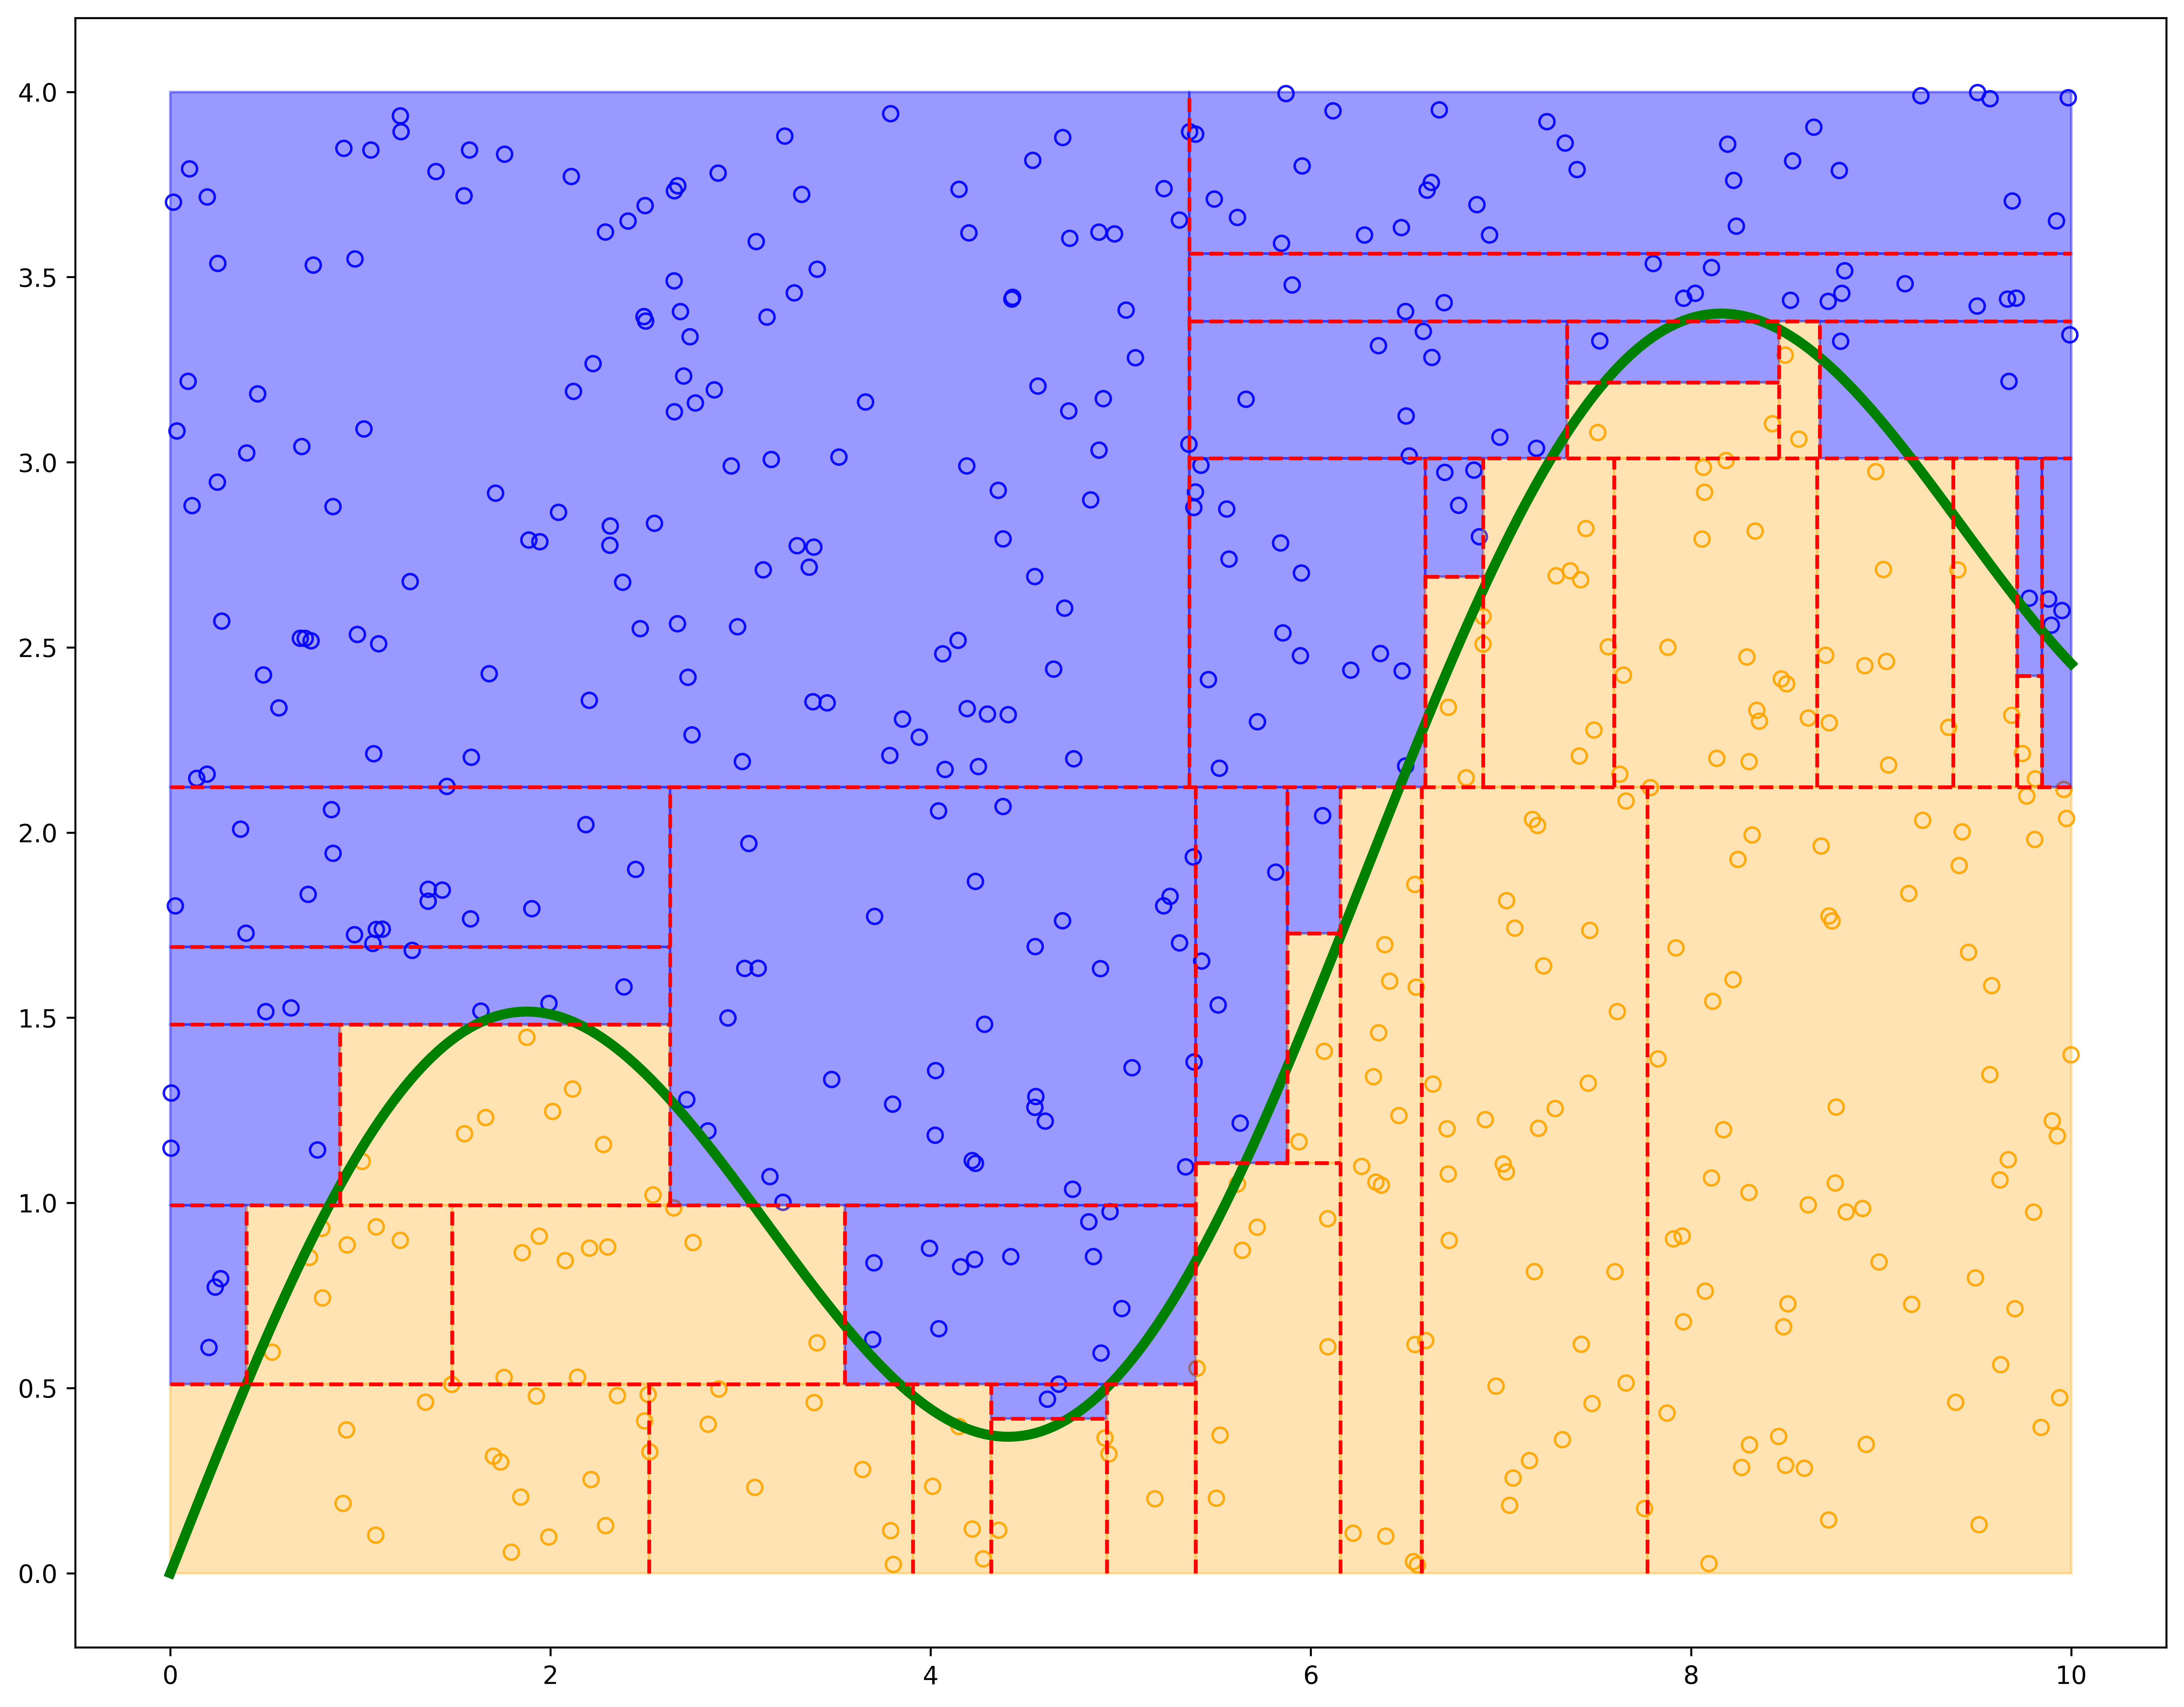

In [12]:
fig2 = plt.figure( figsize=(15,12), dpi=600)
ax1 = fig2.add_subplot()
# 1.
sc = plt.scatter(Yi[:,0], Yi[:,1], alpha=0.9, facecolors='none', edgecolors=cols)
# 2.
plt.plot(np.linspace(0,10,300), [Y(x) for x in np.linspace(0,10,300)] , color='green', linewidth=4)
# calc the coordinates for ploting
coor, rect = geather_coordinates(dg, 'root', 10,0, 4,0)
# 3.
for ((x1, x2), (y1, y2)) in coor:
    plt.plot((x1,x2),(y1,y2), linestyle='--', color='red')
# 4.
for ((x,y), w, h, c) in rect:
    if c == 0:
        r = patches.Rectangle((x, y), w, h, color='blue', alpha=0.4)
    else:
        r = patches.Rectangle((x, y), w, h, color='orange', alpha=0.3)
    ax1.add_patch(r)
plt.show()


### References
*   Hastie, Trevor ; Tibshirani, Robert ; Friedman, Jerome: The Elements of Statistical Learning : Data Mining, Inference, and Prediction. Berlin-Heidelberg: Springer New York, 2017.